In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import time

In [ ]:
os.chdir(os.path.join(os.getcwd(), "data"))

In [9]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [10]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [11]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Outlining the model we're going to build and building a ModelCheckpoint callback

In [12]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


# Creating a data augmentation layer to use with our model

In [15]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Creating a headless EfficientNetB0 model with data augmentation built in

In [17]:
from tensorflow.keras import layers
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Fitting and evaluating our biggest transfer learning model yet

In [19]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

In [20]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.1 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


2023-06-21 12:31:37.715735: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


237/237 [==============================] - 179s 746ms/step - loss: 3.3793 - accuracy: 0.2701 - val_loss: 2.5653 - val_accuracy: 0.4391
Epoch 2/5
237/237 [==============================] - 192s 810ms/step - loss: 2.1957 - accuracy: 0.5002 - val_loss: 2.1099 - val_accuracy: 0.4910
Epoch 3/5
237/237 [==============================] - 165s 695ms/step - loss: 1.8279 - accuracy: 0.5674 - val_loss: 1.9432 - val_accuracy: 0.5109
Epoch 4/5
237/237 [==============================] - 157s 664ms/step - loss: 1.6035 - accuracy: 0.6102 - val_loss: 1.8373 - val_accuracy: 0.5228
Epoch 5/5
237/237 [==============================] - 149s 630ms/step - loss: 1.4632 - accuracy: 0.6375 - val_loss: 1.8045 - val_accuracy: 0.5294


In [21]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 317s 401ms/step - loss: 1.5791 - accuracy: 0.5841


[1.579073429107666, 0.5840792059898376]

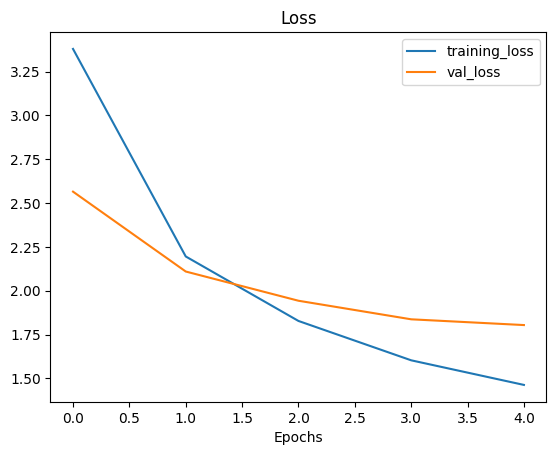

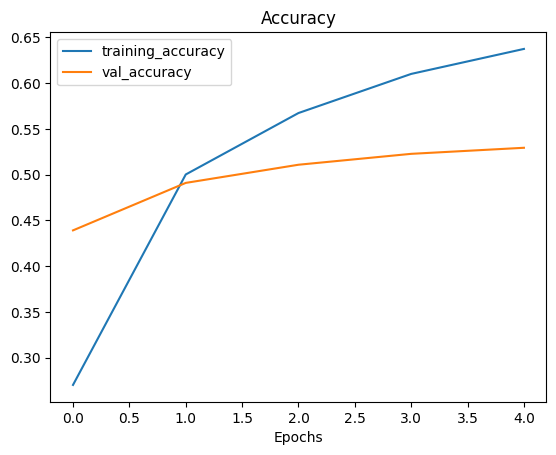

In [22]:
plot_loss_curves(history_all_classes_10_percent)

# Unfreezing some layers in our base model to prepare for fine-tuning

In [23]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [24]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


# Fine-tuning our feature extraction model and evaluating its performance

In [25]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.1 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # st

Epoch 5/10
237/237 [==============================] - 151s 628ms/step - loss: 1.2090 - accuracy: 0.6825 - val_loss: 1.7485 - val_accuracy: 0.5373
Epoch 6/10
237/237 [==============================] - 152s 641ms/step - loss: 1.0965 - accuracy: 0.7059 - val_loss: 1.7195 - val_accuracy: 0.5456
Epoch 7/10
237/237 [==============================] - 165s 699ms/step - loss: 1.0166 - accuracy: 0.7316 - val_loss: 1.7569 - val_accuracy: 0.5410
Epoch 8/10
237/237 [==============================] - 190s 801ms/step - loss: 0.9498 - accuracy: 0.7436 - val_loss: 1.7045 - val_accuracy: 0.5516
Epoch 9/10
237/237 [==============================] - 194s 818ms/step - loss: 0.8884 - accuracy: 0.7642 - val_loss: 1.7446 - val_accuracy: 0.5440
Epoch 10/10
237/237 [==============================] - 201s 847ms/step - loss: 0.8290 - accuracy: 0.7719 - val_loss: 1.7653 - val_accuracy: 0.5371


In [26]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 403s 510ms/step - loss: 1.4939 - accuracy: 0.6025


[1.4938560724258423, 0.6024554371833801]

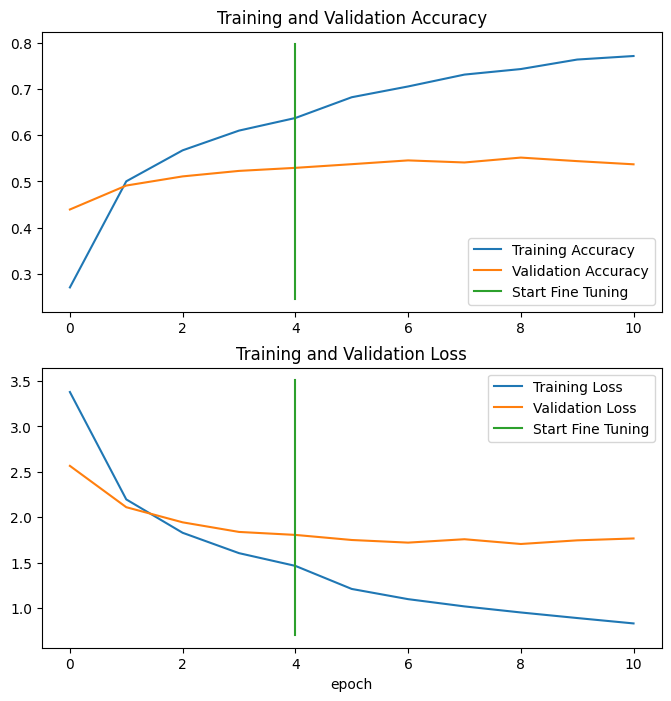

In [27]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving and loading our trained model

In [34]:
# Create the target folder if it doesn't exist
folder_path = "fine_tune_3"
os.makedirs(folder_path, exist_ok=True)

# Save the model
tf.saved_model.save(model, os.path.join(folder_path, "fine_tune_3_model"))

INFO:tensorflow:Assets written to: fine_tune_3/fine_tune_3_model/assets


INFO:tensorflow:Assets written to: fine_tune_3/fine_tune_3_model/assets


# [Not sure why saving model isnt working, but it seems to be a very common problem with saving imagenetb0](https://github.com/keras-team/keras/issues/17199)

In [ ]:
# his way
# Create the target folder if it doesn't exist
folder_path = "fine_tune_3"
os.makedirs(folder_path, exist_ok=True)

# Save the model
model.save(os.path.join(folder_path, "fine_tune_3_model_his_way"))


In [ ]:
# his way
# Load the model
model = tf.keras.models.load_model("fine_tune_3/fine_tune_3_model")


In [36]:
# Load the model
# loaded_model = tf.keras.models.load_model("fine_tune_3/fine_tune_3_model")
# Load the model
loaded_model = tf.saved_model.load("fine_tune_3/fine_tune_3_model")

In [38]:
print(type(loaded_model)) #

<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


In [39]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy

AttributeError: '_UserObject' object has no attribute 'evaluate'

# Making predictions with our trained model on 25,250 test samples

In [29]:
pred_probs = model.predict(test_data, verbose=True) # set verbosity to see how long it will take

790/790 [==============================] - 399s 504ms/step


In [30]:
# How many predictions are there?
len(pred_probs)

25250

In [31]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [32]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [7.00694248e-02 1.25203835e-04 3.91222507e-01 9.81784893e-08
 5.00449642e-06 1.76911067e-06 4.35803850e-05 1.06089365e-05
 1.24154128e-02 2.44285533e-04 1.84171495e-06 7.95886081e-06
 2.89998861e-04 3.04290865e-07 2.33964436e-03 1.14775123e-03
 5.66916106e-06 6.40040613e-04 4.55045793e-03 1.20699078e-05
 6.43592502e-04 2.39898168e-06 1.02987127e-04 3.64539119e-05
 5.93337347e-04 2.21614307e-03 5.23212540e-04 5.87152244e-05
 1.63828596e-01 5.87880088e-04 4.10614120e-06 1.39489688e-03
 7.96937675e-04 8.03144474e-07 4.87223081e-03 1.14061540e-05
 1.79761555e-04 6.32754003e-04 7.80580267e-02 6.77768985e-05
 2.45688745e-04 5.34309307e-03 2.63537542e-04 2.70915780e-06
 8.90320953e-05 7.35898857e-06 1.07262295e-03 9.18227233e-05
 8.32313901e-07 4.78519872e-02 1.19692260e-04 7.25310165e-05
 5.26434854e-02 2.44851597e-02 2.97143633e-05 3.34665598e-03
 1.31377978e-02 1.02336344e-03 1.65033306e-

In [33]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 2,  0,  0,  8,  8, 78, 29,  0,  9,  0])

# Unravelling our test dataset for comparing ground truth labels to predictions

In [46]:
from tqdm import tqdm

y_labels = []
total_batches = len(test_data) # Total number of batches in test_data

# Iterate over test_data with tqdm
for images, labels in tqdm(test_data.unbatch(), total=total_batches, desc="Processing data"):
    y_labels.append(labels.numpy().argmax())

y_labels[:10] # Check what they look like (unshuffled)


Processing data: 25250it [00:11, 2276.24it/s]                       


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Confirming our model's predictions are in the same order as the test labels

In [47]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6024554455445544

In [50]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
# import numpy as np
# print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

# Creating a confusion matrix for our model's 101 different classes

In [52]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [57]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [59]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.35      0.19      0.24       250
           1       0.53      0.73      0.62       250
           2       0.63      0.60      0.62       250
           3       0.91      0.44      0.59       250
           4       0.61      0.36      0.45       250
           5       0.44      0.39      0.42       250
           6       0.82      0.75      0.79       250
           7       0.85      0.75      0.80       250
           8       0.27      0.53      0.36       250
           9       0.46      0.64      0.54       250
          10       0.44      0.45      0.45       250
          11       0.77      0.57      0.66       250
          12       0.73      0.58      0.65       250
          13       0.52      0.58      0.55       250
          14       0.61      0.52      0.56       250
          15       0.43      0.34      0.38       250
          16       0.66      0.56      0.61       250
          17       0.40    

In [61]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.34558823529411764,
  'recall': 0.188,
  'f1-score': 0.24352331606217612,
  'support': 250},
 '1': {'precision': 0.5304347826086957,
  'recall': 0.732,
  'f1-score': 0.6151260504201681,
  'support': 250},
 '2': {'precision': 0.6329113924050633,
  'recall': 0.6,
  'f1-score': 0.6160164271047229,
  'support': 250},
 '3': {'precision': 0.9090909090909091,
  'recall': 0.44,
  'f1-score': 0.5929919137466306,
  'support': 250},
 '4': {'precision': 0.6054421768707483,
  'recall': 0.356,
  'f1-score': 0.44836272040302266,
  'support': 250},
 '5': {'precision': 0.44144144144144143,
  'recall': 0.392,
  'f1-score': 0.4152542372881356,
  'support': 250},
 '6': {'precision': 0.8245614035087719,
  'recall': 0.752,
  'f1-score': 0.7866108786610879,
  'support': 250},
 '7': {'precision': 0.8538812785388128,
  'recall': 0.748,
  'f1-score': 0.7974413646055437,
  'support': 250},
 '8': {'precision': 0.26814516129032256,
  'recall': 0.532,
  'f1-score': 0.35656836461126007,
  'suppo

Since the f1-score combines precision and recall in one metric, let's focus on that.

In [62]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores


{'apple_pie': 0.24352331606217612,
 'baby_back_ribs': 0.6151260504201681,
 'baklava': 0.6160164271047229,
 'beef_carpaccio': 0.5929919137466306,
 'beef_tartare': 0.44836272040302266,
 'beet_salad': 0.4152542372881356,
 'beignets': 0.7866108786610879,
 'bibimbap': 0.7974413646055437,
 'bread_pudding': 0.35656836461126007,
 'breakfast_burrito': 0.5378151260504201,
 'bruschetta': 0.44621513944223107,
 'caesar_salad': 0.657471264367816,
 'cannoli': 0.6473214285714286,
 'caprese_salad': 0.5461393596986818,
 'carrot_cake': 0.560344827586207,
 'ceviche': 0.38392857142857145,
 'cheese_plate': 0.6073752711496746,
 'cheesecake': 0.42725598526703495,
 'chicken_curry': 0.48169556840077066,
 'chicken_quesadilla': 0.6652892561983471,
 'chicken_wings': 0.7456896551724138,
 'chocolate_cake': 0.56,
 'chocolate_mousse': 0.3592592592592593,
 'churros': 0.7337526205450734,
 'clam_chowder': 0.7179487179487181,
 'club_sandwich': 0.6908315565031983,
 'crab_cakes': 0.3536842105263158,
 'creme_brulee': 0.77618

In [63]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.962672
63,macarons,0.901288
75,pho,0.865979
69,oysters,0.859438
86,sashimi,0.850806


# Plotting our model's F1-scores for each separate class

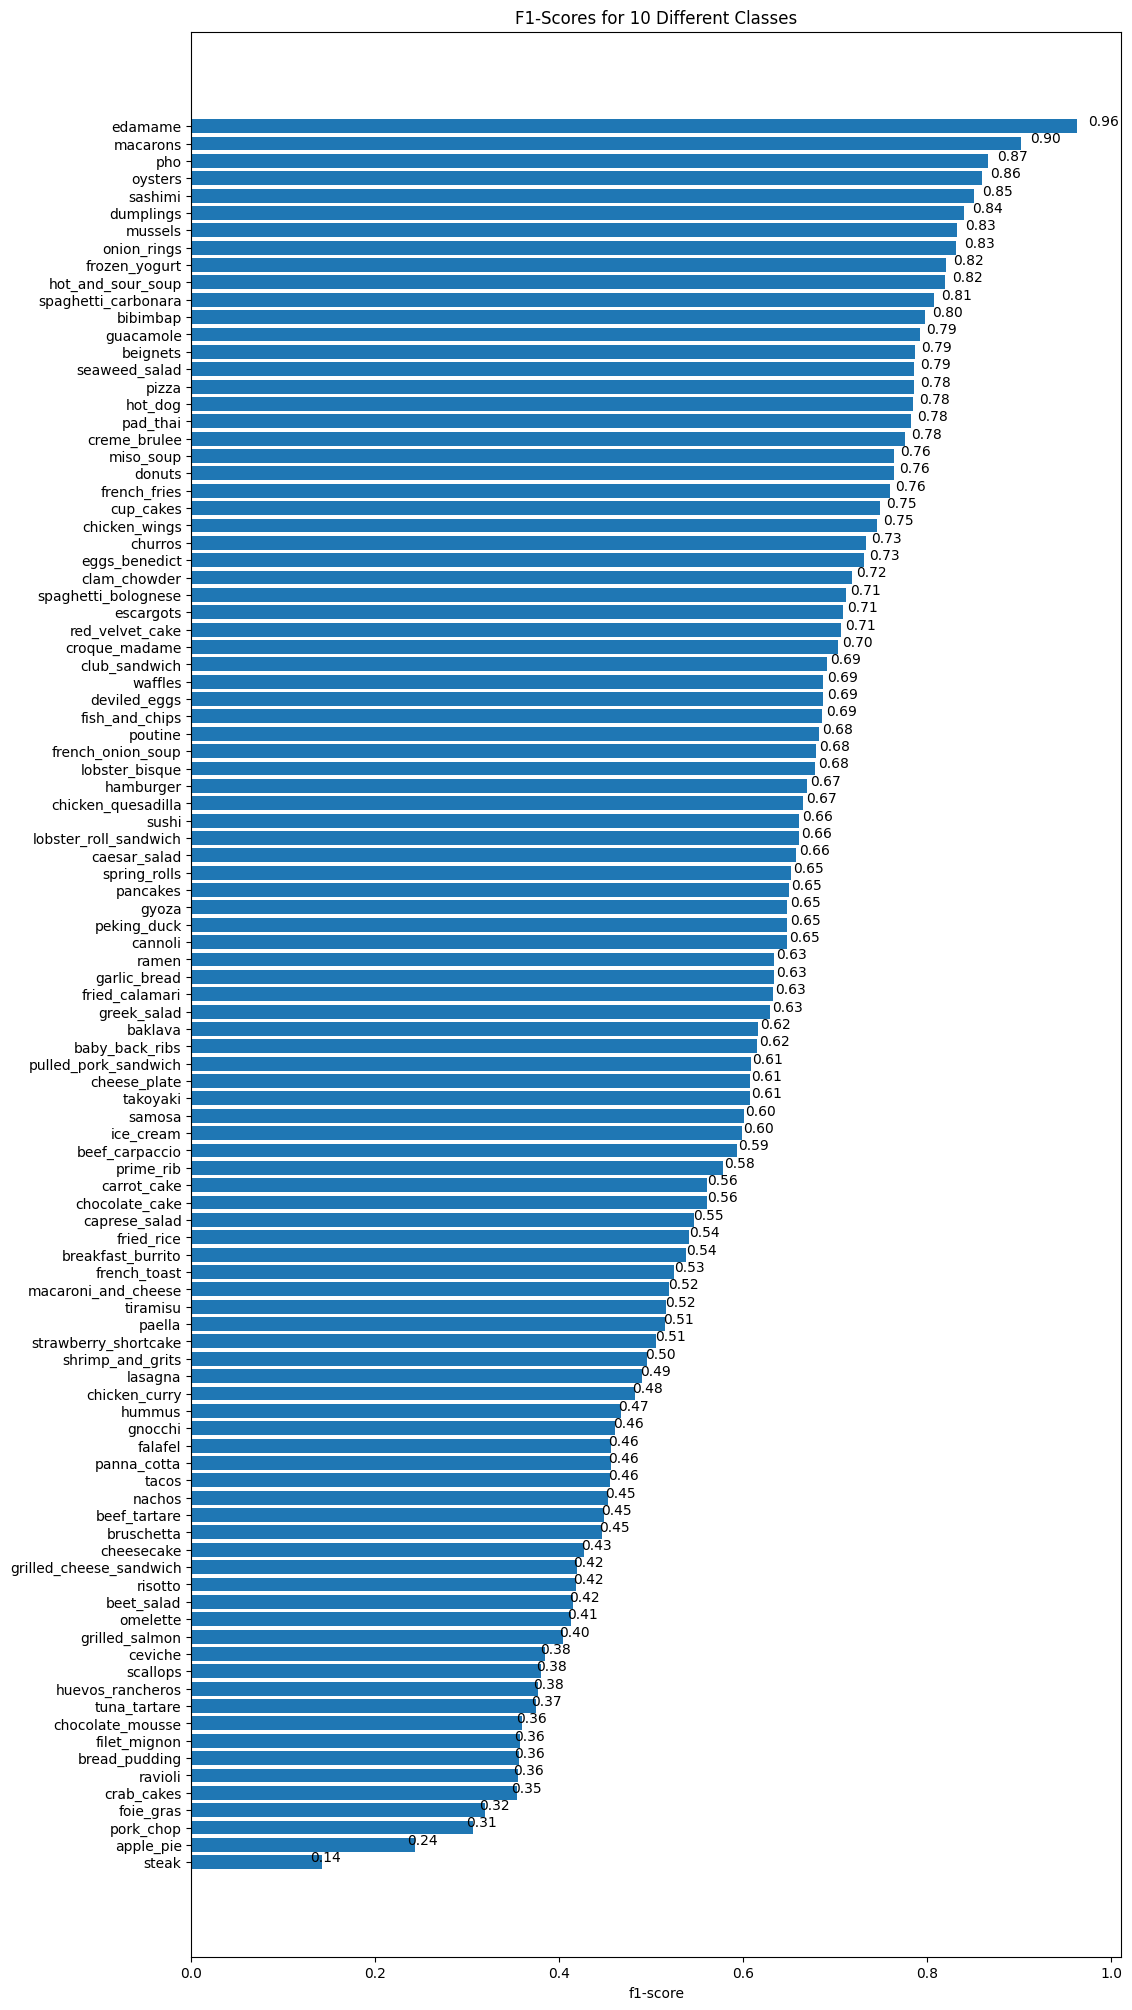

In [64]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Creating a function to load and prepare images for making predictions